In [1]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from torch.utils.data import DataLoader, TensorDataset

np.random.seed(1337)

# Load and process the data
aggregate_df1 = pd.read_csv('/home/awinlab/Documents/kevin/elec110.csv', index_col='datetime', parse_dates=True)
aggregate_df1 = aggregate_df1[:900000:10]

plug1_1 = pd.read_csv('/home/awinlab/Documents/kevin/plug1-1.csv', index_col='datetime', parse_dates=True)
plug1_1 = plug1_1[:900000:10]

aggregate_df1 = aggregate_df1.drop(['Unnamed: 0','id','device', 'vo', 'cu', 'reactive', 'apparent', 'pf', 'freq'], axis=1)
plug1_1 = plug1_1.drop(['Unnamed: 0','id','device', 'vo', 'cu', 'reactive', 'apparent', 'pf', 'freq'], axis=1)

/home/awinlab/anaconda3/envs/daniel_flower/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


 torch.nn.utils.rnn.pack_sequence 來保留每個時間序列之間的關係，並使用 torch.nn.utils.rnn.pad_sequence 來將所有序列的長度調整為最長序列的長度。

In [2]:
class TimeSeriesDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, length=100):
        self.X = X
        self.y = y
        self.length = length

    def __len__(self):
        return len(self.X) - self.length

    def __getitem__(self, idx):
        X = self.X[idx: idx + self.length]
        y = self.y[idx: idx + self.length]
        return X, y

training_size = int(len(aggregate_df1) * 0.8)
X_train = aggregate_df1[training_size:]
X_test = aggregate_df1[:training_size]

y_train = plug1_1[training_size:]
y_test = plug1_1[:training_size]

X_train = torch.tensor(X_train.values).float()
X_test = torch.tensor(X_test.values).float()
y_train = torch.tensor(y_train.values).float()
y_test = torch.tensor(y_test.values).float()

batch_size=60

train_dataset = TimeSeriesDataset(X_train, y_train, length=100)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, 
                                           collate_fn=lambda x: (torch.nn.utils.rnn.pad_sequence([i[0] for i in x], batch_first=True),
                                                                 torch.nn.utils.rnn.pad_sequence([i[1] for i in x], batch_first=True)))

test_dataset = TimeSeriesDataset(X_test, y_test, length=100)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, 
                                           collate_fn=lambda x: (torch.nn.utils.rnn.pad_sequence([i[0] for i in x], batch_first=True),
                                                                 torch.nn.utils.rnn.pad_sequence([i[1] for i in x], batch_first=True)))

In [3]:
class TimeSeriesDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, length=100):
        self.X = X
        self.y = y
        self.length = length

    def __len__(self):
        return len(self.X) - self.length

    def __getitem__(self, idx):
        X = self.X[idx: idx + self.length]
        y = self.y[idx: idx + self.length]
        return X, y


In [4]:
import torch.nn.functional as F
class ConvolutionalModel(nn.Module):
    def __init__(self, input_shape, n_input):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=100, out_channels=8, kernel_size=4, padding=2, stride=1, bias=True)
        self.dropout1 = nn.Dropout(p=0.2)
        self.fc0 = nn.Linear(16,(n_input-0)*8)
        self.fc1 = nn.Linear((n_input-0)*8, 128)
        self.dropout2 = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(in_features=128, out_features=(n_input-0)* 8)
        self.dropout3 = nn.Dropout(p=0.2)
        self.fc3 = nn.Linear(in_features=(n_input-0) * 8, out_features=128)
        self.dropout4 = nn.Dropout(p=0.2)
        self.conv2 = nn.Conv1d(8, 1, kernel_size=4, padding=2, stride=1)

        self.fc4 = nn.Linear(17, 1)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = x.view(x.size(0), -1)
        x = self.dropout1(x)
        x = self.fc0(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout3(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.dropout4(x)
        x = x.view(x.size(0), 8, -1)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = self.fc4(x)
        return x

n_input = 100
input_shape = (n_input, 1)
model = ConvolutionalModel(input_shape, n_input)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08)

In [5]:
from torch.nn import L1Loss
import matplotlib.pyplot as plt


mae_fn = L1Loss()

num_epochs = 5
for epoch in range(num_epochs):
    
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.reshape(-1, 100, 1)
#         model.zero_grad()
        y_pred = model(X_batch) 
        loss = loss_fn(y_pred.view(-1), y_batch.view(-1,1))
#         optimizer.zero_grad()
        mae = mae_fn(y_pred.view(-1), y_batch.view(-1,1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f"Epoch {epoch+1}, Loss: {loss.item()}, MAE: {mae.item()}")

/home/awinlab/anaconda3/envs/daniel_flower/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([6000, 1])) that is different to the input size (torch.Size([60])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/awinlab/anaconda3/envs/daniel_flower/lib/python3.7/site-packages/torch/nn/modules/loss.py:97: UserWarning: Using a target size (torch.Size([6000, 1])) that is different to the input size (torch.Size([60])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/awinlab/anaconda3/envs/daniel_flower/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([2000, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorre

Epoch 1, Loss: 1.232376217842102, MAE: 0.8898306488990784
Epoch 2, Loss: 0.6043311953544617, MAE: 0.6656430959701538
Epoch 3, Loss: 0.7142369151115417, MAE: 0.6441158056259155
Epoch 4, Loss: 0.8432398438453674, MAE: 0.7878010869026184
Epoch 5, Loss: 0.9728822112083435, MAE: 0.8279955983161926


In [6]:
predict = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        predict.append(outputs)

In [7]:
predict_list = np.concatenate([p.detach().numpy() for p in predict], axis=0)

In [8]:
y_val = plug1_1 = plug1_1[:900000]
y_val = y_val[:training_size]
y_val = y_val.values.reshape(y_val.shape[0])

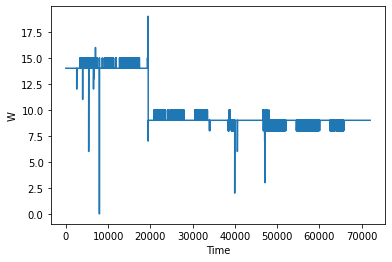

In [9]:
plt.plot(y_val)
# plt.plot(predict_list,color='darkorange')
plt.xlabel('Time')
plt.ylabel("W")
plt.show()

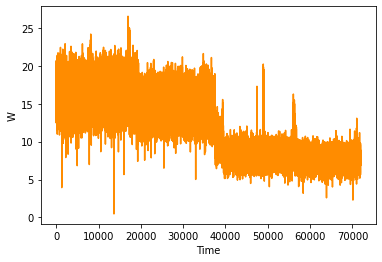

In [10]:
plt.plot(predict_list,color='darkorange')
plt.xlabel('Time')
plt.ylabel("W")
plt.show()